In [2267]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101, resnet152

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

from scipy.special import softmax

import seaborn as sn

from os import listdir, path
from PIL import Image
from collections import defaultdict
import csv
import re
import os
import random

from IPython.display import display, clear_output, Image as IPython_Image

In [2268]:
pwd

'/scratch/project_2003030/notebooks'

In [2269]:
torch.cuda.is_available()

True

# Data loading

In [2270]:
DATA_PATH = '../data'
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights). These were calculated using
# the function calculate_label_statistics (present in notebook 08, but removed from 09 as unnecessary to keep) 
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [2271]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [2272]:
def get_class_map():
    ret = {}

    i = 0
    for fname in sorted(listdir(LABEL_PATH)):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [2273]:
def calculate_label_statistics(label_array, total_n_images):
    """Calculate label statistics to be used as pos_weights in BCEWithLogitsLoss. This was used to calculate the
    values saved in the variable label_pos_weights_for_loss (no need to recalculate as these don't change in the
    given training data set).

    Args:
        label_array (array): n x m array of labels, where n is number of samples and m is number of labels
        total_n_images (int): total number of images in the set that the labels are from. Equals len(n).
    """
    label_arr = np.array(label_array).astype(int)
    pos_label_counts_all = np.sum(label_arr, axis=0)
    neg_label_counts_all = total_n_images - pos_label_counts_all
    relative_label_occurrances =  pos_label_counts_all/total_n_images
    pos_weights = neg_label_counts_all / pos_label_counts_all
    
    return pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances

In [2274]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [2275]:
def get_data(train_fr=.6, max_images_per_class=1e9, LABEL_PATH=LABEL_PATH, IMAGE_PATH=IMAGE_PATH):
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in sorted(listdir(LABEL_PATH)):
        img_label, _ = fname.split('.')
        img_class = class_map[img_label]
        print(f'Reading label: {img_label}, img_class: {img_class}')
        
        # open the annotation file
        i = 0
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # append to dict
                    img_to_data[img_id] = img.convert('RGB')

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class = class_map[img_label]
                img_classes[img_class] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break

                i += 1

    # load also all the images that do not have any labels
    i = 0
    print(f'Reading images without labels..')
    for fname in listdir(IMAGE_PATH):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        if img_id not in img_to_data:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)

            # append to dict
            img_to_data[img_id] = img.convert('RGB')

            if i >= max_images_per_class:
                break

            i += 1

    print('Creating train/valid/test split..')
    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    if train_fr == 1:
        print('Done.')
        return X, [], [], y, [], []
        
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    print('Done.')
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [2276]:
def get_test_data(test_image_path):
    
    # dictionary to hold the image data
    img_to_data = dict()
    
    # loop through all the test images
    i = 0
    print(f'Reading test images..')
    for fname in listdir(test_image_path):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        img_path = f'{test_image_path}/im{img_id}.jpg'
        img = Image.open(img_path)

        # append to dict
        img_to_data[img_id] = img.convert('RGB')
        i += 1

    # collect data to a single array
    X = []
    for img_id in sorted(img_to_data.keys()):
        X.append(img_to_data[img_id])
   
    print('Done.')
    return X

In [2277]:
class TransformingDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_data = self.X[idx]
        img_class = self.y[idx]

        if self.transforms:
            img_data = self.transforms(img_data)

        return img_data, img_class

In [2278]:
class TransformingTestDataset(torch.utils.data.Dataset):
    def __init__(self, X, transforms=None):
        self.X = X
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_data = self.X[idx]

        if self.transforms:
            img_data = self.transforms(img_data)

        return img_data

# Models

In [2279]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        #self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = x.reshape(-1, 128*128*3)
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [2280]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes): #OneLayerModel(128*128*3, 128, n_classes).to(device)
        super().__init__()
        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        x = x.reshape(-1, 128*128*3)
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [2281]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

In [2282]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=392, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*4*392, out_features=14)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc1(out)
        return out    

# Training and evaluation functions

In [2283]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = torch.sigmoid(model(X))

            loss = criterion(y_pred, y)
            losses.append(loss)

            score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
            f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [2284]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True, threshold=0.5, n_report_fr=10):
    model.train()
    
    train_losses, valid_losses = [], []
    train_scores, valid_scores = [], []

    fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
    print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            if verbose and i % n_report_fr == 0:
                print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')
            
        if verbose:            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        train_loss, train_score = evaluate(train_dataloader, model, criterion, device, threshold)
        valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device, threshold)
        
        train_losses.append(train_loss)
        train_scores.append(train_score)
        valid_losses.append(valid_loss)
        valid_scores.append(valid_score)

        fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
        print(fmt.format(epoch+1, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')
    
    return train_losses, valid_losses, train_scores, valid_scores

# Visualization functions

In [2285]:
def visualize_true_positives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if img_class in pred_classes and img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, threshold=threshold, predicate=predicate)

In [2286]:
def visualize_true_negatives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if not img_class in pred_classes and not img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, threshold=threshold, predicate=predicate)

In [2287]:
def visualize_false_positives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if img_class in pred_classes and not img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, threshold=threshold, predicate=predicate)

In [2288]:
def visualize_false_negatives(img_label, model, device, dataloader, n_to_show=10, threshold=0.75):

    class_map = get_class_map()
    img_class = class_map[img_label]

    def predicate(pred_classes, true_classes):
        return True if not img_class in pred_classes and img_class in true_classes else False

    visualize_predictions(model, device, dataloader, n_to_show=n_to_show, threshold=threshold, predicate=predicate)

In [2289]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=10, threshold=0.5, predicate=None):

    model.eval()

    if predicate == None:
        predicate = lambda p1, p2: True

    class_to_label = { v: k for k, v in get_class_map().items() }
    
    n_shown = 0
    for i, batch in enumerate(dataloader):
        X, y = batch
        X = X.to(device)

        y_pred = torch.sigmoid(model(X).cpu()) > threshold
        y = y == 1
        
        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            if not predicate(pred_classes, true_classes):
                continue

            show_image_with_predictions(X[i], true_classes, pred_classes)

            n_shown += 1
            
            if n_shown >= n_to_show:
                return            

In [2290]:
def show_image_with_predictions(X, true_classes, pred_classes, mean=MEAN, std=STD):
    
    class_map = get_class_map()
    class_to_label = { v: k for k, v in class_map.items() }

    true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
    pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))

    img = inv_transform(X.cpu()) # inverse transforms
    img = img.permute(2, 1, 0)   # BGR -> RGB
    img = np.rot90(img, 3)

    plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
    plt.imshow(img)
    plt.pause(0.001)

In [2291]:
def visualize_images_from_disk(img_label, n_to_show=5, random_images=True):

    # open the annotations file for this label
    with open(f'{LABEL_PATH}/{img_label}.txt', 'r') as fh:

        # read in image ids
        img_ids = fh.read().splitlines()

        # shuffle, if we want to display random images
        if random_images:
            random.shuffle(img_ids)

        # display the images
        n_shown = 0
        for img_id in img_ids:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)
 
            plt.title(f'True: {img_label}, img_id: {img_id}')
            plt.imshow(img)
            plt.pause(0.001)

            if n_shown >= n_to_show:
                return

            n_shown += 1

In [2292]:
def visualize_images_from_dataloader(img_label, dataloader, mean=MEAN, std=STD, n_to_show=5):
    class_map = get_class_map()
    img_class = class_map[img_label]

    n_shown = 0
    for batch in dataloader:
        X, y = batch

        for i in range(len(y)):
            true_classes = y[i]

            # if image does not belong to wanted class, skip
            if not true_classes[img_class]:
                continue

            # display the image
            inv_transform = transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))

            img = inv_transform(X[i]) # inverse transforms
            img = img.permute(2, 1, 0) # BGR -> RGB
            img = np.rot90(img, 3)

            plt.title(f'Image label: {img_label}, Image class: {img_class}')
            plt.imshow(img)
            plt.pause(0.001)

        if n_shown >= n_to_show:
            return

        n_shown += 1

In [2293]:
def visualize_images_from_sets(img_label, X, y, n_to_show=5):
    class_map = get_class_map()
    img_class = class_map[img_label]

    n_shown = 0
    for i in range(len(y)):

        # if image does not have this label, skip it
        if not y[i][img_class]:
            continue

        # display the image
        img = X[i]
        plt.title(f'Image label: {img_label}, Image class: {img_class}')
        plt.imshow(img)
        plt.pause(0.001)

        if n_shown >= n_to_show:
            return

        n_shown += 1

In [2294]:
def predict(model, device, dataloader, threshold=0.70):
    y_pred = torch.tensor([], device=device, dtype=torch.uint8)
    y_true = torch.tensor([], device=device, dtype=torch.uint8)
    
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch

            X = X.to(device)
            y = y.to(device).type(torch.uint8)

            y_pred_tmp = torch.sigmoid(model(X)) > threshold
            y_pred_tmp = y_pred_tmp.type(torch.uint8)

            y_pred = torch.cat((y_pred, y_pred_tmp), 0)
            y_true = torch.cat((y_true, y), 0)

    return y_pred, y_true
    
def predict_testdata(model, device, dataloader, threshold=0.70):
    y_pred = torch.tensor([], device=device, dtype=torch.uint8)
    
    model.eval()

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)

            y_pred_tmp = torch.sigmoid(model(X)) > threshold
            y_pred_tmp = y_pred_tmp.type(torch.uint8)

            y_pred = torch.cat((y_pred, y_pred_tmp), 0)

    return y_pred

def get_prediction_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    (tn, fp, fn, tp) = tuple(cm.flatten())
    
    # Precision, recall, f1-score, support
    prec, rec, support = tp/(tp+fp), tp/(tp+fn), tp+fn
    f1 = 2*prec*rec/(prec+rec)
    score = dict([(k, v[1]) for k, v in zip(['precision', 'recall', 'f1-score', 'support'], 
         precision_recall_fscore_support(y_true, y_pred, average=None))])
    
    return cm, score

In [2295]:
def visualize_confusion_matrix(y_true, y_pred, labels, file_path, no_label_cn=None, no_label_score=None):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)
    
    # Add non-label scores
    if no_label_cn is not None and no_label_score is not None:
        cn_tensor = np.concatenate((cn_tensor, no_label_cn[None]), axis=0)
        scores['14'] = no_label_score

    fig, ax = plt.subplots(nrows=6, ncols=3, sharey=True, figsize=(20, 24), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()

    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        ax[j, k].set_ylim([0,2])
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
    # Dirty hack: to fix matplotlib and sns incompatibility (positioning annotations)
    sn.heatmap(np.array([[0,0],[0,0]]), annot=np.array([['',''],['','']]), fmt='', cmap='Blues', ax=ax[5, 0])
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    
    # Fix image size after hack
    img = Image.open(file_path).crop((0, 0, 1200, 1150)).save(file_path, 'png')

In [2296]:
def plot_learning_curves(tr_losses, val_losses, tr_scores, val_scores, file_path, title):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    ax[0].plot(range(n_epochs), val_losses, label='Validation')
    ax[0].plot(range(n_epochs), tr_losses, label='Train')
    ax[0].set_title('Loss', fontsize=14)

    ax[1].plot(range(n_epochs), val_scores, label='Validation')
    ax[1].plot(range(n_epochs), tr_scores, label='Train')
    ax[1].set_title('F1-score', fontsize=14)

    plt.legend(loc='center', ncol=2, bbox_to_anchor=(-.15, 1.15), fontsize=14)
    plt.suptitle(title, fontsize=16, y=1.1)
    
    # Save learning curve plot
    plt.savefig(file_path)
    plt.show()

# Do the magic!

In [2297]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 25
bs = 64
n_classes = len(get_class_map().keys())
threshold = 0.75
#model_name = 'cnn'
#model_name = 'ffn1'
#model_name = 'ffn2'
#model_name = 'vgg16'
#model_name = 'vgg16_bn'
#model_name = 'resnet18'
#model_name = 'resnet34'
#model_name = 'resnet50'
#model_name = 'resnet50_noaug'
model_name = 'resnet50_noaug_dropout'
#model_name = 'resnet50_plain'
#model_name = 'resnet101'
#model_name = 'resnet152'

Using GPU!


## Create and save / load dataloaders from disk

In [2298]:
class RandomIndividualApply():
    """Apply randomly a list of transformations with a given probability

    Args:
        transforms (list or tuple): list of transformations
        p (float): probability
    """

    def __init__(self, transforms, p=0.5):
        self.p = p
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            if self.p < np.random.random():
                continue
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += '\n    p={}'.format(self.p)
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string

In [2299]:
max_images_per_class = int(1e9)
#max_images_per_class = 200

transformations = {
    'train': transforms.Compose([
        RandomIndividualApply([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((-10, 10)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomPerspective(),
        ], p=0.5),
        transforms.ToTensor(),                
        transforms.Normalize(mean=MEAN, std=STD)            
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
}

if model_name == 'resnet50_noaug' or model_name == 'resnet50_noaug_dropout':
    transformations['train'] = transformations['valid']

if not os.path.isfile(f'../data/X_train_n{max_images_per_class}.dat'):
    print('Loading all data from disk.')
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(max_images_per_class=max_images_per_class)
    torch.save(X_train, f'../data/X_train_n{max_images_per_class}.dat')
    torch.save(X_valid, f'../data/X_valid_n{max_images_per_class}.dat')
    torch.save(X_test, f'../data/X_test_n{max_images_per_class}.dat')
    torch.save(y_train, f'../data/y_train_n{max_images_per_class}.dat')
    torch.save(y_valid, f'../data/y_valid_n{max_images_per_class}.dat')
    torch.save(y_test, f'../data/y_test_n{max_images_per_class}.dat')
    print(' - Done.')
else:
    print('Loading saved torch dump from disk.')
    X_train = torch.load(f'../data/X_train_n{max_images_per_class}.dat')
    X_valid = torch.load(f'../data/X_valid_n{max_images_per_class}.dat')
    X_test = torch.load(f'../data/X_test_n{max_images_per_class}.dat')
    y_train = torch.load(f'../data/y_train_n{max_images_per_class}.dat')
    y_valid = torch.load(f'../data/y_valid_n{max_images_per_class}.dat')
    y_test = torch.load(f'../data/y_test_n{max_images_per_class}.dat')
    print(' - Done.')

train_dataloader = DataLoader(
    TransformingDataset(X_train, y_train, transforms=transformations['train']),
    shuffle=True,
    batch_size=bs)

valid_dataloader = DataLoader(
    TransformingDataset(X_valid, y_valid, transforms=transformations['valid']),
    shuffle=True,
    batch_size=bs)

test_dataloader = DataLoader(
    TransformingDataset(X_test, y_test, transforms=transformations['test']),
    shuffle=True,
    batch_size=bs)

Loading saved torch dump from disk.
 - Done.


## Basic models

In [2300]:
if model_name == 'ffn1':
    model = OneLayerModel(128*128*3, 128, n_classes).to(device)

In [2301]:
if model_name == 'ffn2':
    model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)

In [2302]:
if model_name == 'cnn':
    model = ConvNetModel(n_classes=n_classes, keep_prob=.5).to(device)

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

From: https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560 
*Usually if your use case stays in the same data domain, the mean and std won’t be that different and you can try to use the ImageNet statistics.
I would recommend to use your own data statistics if you are dealing with another domain, e.g. medical images.*


More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67. 

Now around 0.71 with one cycle policy.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [2303]:
if model_name == 'vgg16' or model_name == 'vgg16_bn':
    
    if model_name == 'vgg16':
        model = vgg16(pretrained=True).to(device)
    else:
        model = vgg16_bn(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        #nn.Dropout(p=.5),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        #nn.Dropout(p=.2),
        nn.Linear(2048, 14),
    ).to(device)
    

_RESNET_


In [2304]:
if model_name == 'resnet18':
    model = resnet18(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [2305]:
if model_name == 'resnet34':
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [2306]:
if model_name == 'resnet50' or model_name == 'resnet50_noaug' or model_name == 'resnet50_noaug_dropout':
    model = resnet50(pretrained=True).to(device)
    
    if model_name == 'resnet50_noaug_dropout':
        print('Using dropout')
        model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

Using dropout


In [2307]:
if model_name == 'resnet101':
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [2308]:
if model_name == 'resnet152':
    model = resnet152(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [2309]:
# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    base_momentum=0.5,
    max_momentum=0.95,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [2316]:
%time tr_losses, val_losses, tr_scores, val_scores = \
    train(train_dataloader, valid_dataloader,\
          model, optimizer, scheduler, criterion, device,\
          n_epochs=n_epochs, verbose=False, threshold=threshold)

Epoch Train loss   Valid loss   Train F1  Valid F1 
1     1.0881490929 1.1048901196 0.6135094 0.5949420
2     1.0262076327 1.0592714163 0.7102419 0.6688853
3     1.0012112884 1.0426386224 0.7560402 0.6893011
4     0.9845743361 1.0350796659 0.8078935 0.7090963
5     0.9714433703 1.0431887102 0.8563618 0.7312829
6     0.9636249560 1.0441155874 0.8903180 0.7398630
7     0.9572799172 1.0443486961 0.9168624 0.7417624
8     0.9527046526 1.0513164559 0.9346004 0.7414251
9     0.9487634178 1.0545188204 0.9585394 0.7425364
10    0.9465494793 1.0541145292 0.9680609 0.7474094
11    0.9437289809 1.0547511514 0.9754636 0.7430071
12    0.9419758049 1.0551977438 0.9799384 0.7370297
13    0.9410989267 1.0564414950 0.9837415 0.7393411
14    0.9402686741 1.0589676380 0.9863337 0.7402042
15    0.9388740252 1.0593943782 0.9902447 0.7445804
16    0.9385266839 1.0610028544 0.9913496 0.7431671
17    0.9378212549 1.0607657932 0.9906473 0.7377075
18    0.9373529389 1.0614484176 0.9947011 0.7446712
19    0.9374

In [2317]:
avg_loss, avg_f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
print(f'Threshold {threshold}: mean loss {avg_f1:.3}, mean F1-score {avg_f1:.3}')

Threshold 0.75: mean loss 0.742, mean F1-score 0.742


In [2318]:
# Save a model on disk to continue training later
if True:
    model_whole_save_path = f'../data/{model_name}-epochs{n_epochs}-bs{bs}-valid-F1-{avg_f1:.3}.pth'
    print(f'Saving model to {model_whole_save_path}')
    torch.save(model, model_whole_save_path)

Saving model to ../data/resnet50_noaug_dropout-epochs25-bs64-valid-F1-0.742.pth


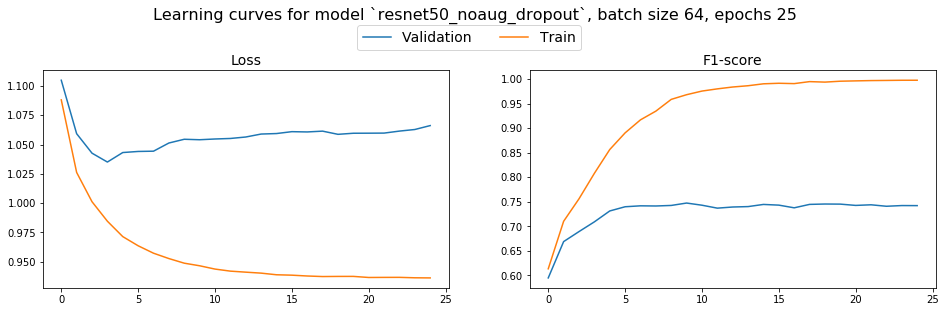

In [2319]:
# Learning curve
if True:
    title = f'Learning curves for model `{model_name}`, batch size {bs}, epochs {n_epochs}'
    file_path = f'../results/{model_name}-epochs{n_epochs}-bs{bs}-valid-F1-{avg_f1:.3}_learningcurve.png'
    plot_learning_curves(tr_losses, val_losses, tr_scores, val_scores, file_path, title)

In [2320]:
# This is for finding the optimal threshold.
if False:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

# Visualization and evaluation

## Image loading debugging

In [2321]:
debug_images = False

### Show images directly from the given data

In [2322]:
if debug_images:
    visualize_images_from_disk('baby', n_to_show=5)

### Show images from the X_train/y_train, X_valid/y_valid, or X_test/y_test

In [2323]:
if debug_images:
    visualize_images_from_sets('baby', X_train, y_train, n_to_show=5)

### Show images from the dataloader

In [2324]:
if debug_images:
    visualize_images_from_dataloader('baby', train_dataloader, n_to_show=5)

## Visualize predictions

### Show some images with predictions

In [2325]:
if False:
    visualize_predictions(model, device, test_dataloader, n_to_show=5, threshold=0.7)

#### TP/FP/TN/FN

In [2326]:
threshold = 0.65
visualize_tpfptnfn = False
img_label = 'baby'

In [2327]:
if visualize_tpfptnfn:
    visualize_false_positives(img_label, model, device, valid_dataloader, threshold=threshold, n_to_show=5)

In [2328]:
if visualize_tpfptnfn:
    visualize_false_negatives(img_label, model, device, valid_dataloader, threshold=threshold, n_to_show=5)

In [2329]:
if visualize_tpfptnfn:
    visualize_true_positives(img_label, model, device, valid_dataloader, threshold=threshold, n_to_show=5)

In [2330]:
if visualize_tpfptnfn:
    visualize_true_negatives(img_label, model, device, valid_dataloader, threshold=threshold, n_to_show=5)

# Predict and evaluate using our own test data

## Load our best model

In [2367]:
model = torch.load('../data/resnet50-epochs25-bs64-valid-F1-0.74.pth')
model_name = 'resnet50'

In [2375]:
if True:
    model_name = 'resnet152_plain'
    model = resnet152(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)
    model.eval()

## Predict using our own test data using ```test_dataloader``` (already loaded)

In [2376]:
print(model_name)

# Predict 
y_true, y_pred = predict(model, device, test_dataloader, threshold=threshold)
y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy()

# Save results to disk
path_pred, path_true = f'../results/{model_name}_pred.txt', f'../results/{model_name}_true.txt'
np.savetxt(path_pred, y_pred, fmt='%d')
np.savetxt(path_true, y_true, fmt='%d')
print(f'Saved results in {path_pred}, {path_true}')

resnet152_plain
Saved results in ../results/resnet152_plain_pred.txt, ../results/resnet152_plain_true.txt


## Run test_eval.py against our own test data

In [2377]:
%run "../scripts/test_eval.py" $path_pred $path_true

../results/resnet152_plain_true.txt: f1=0.05629509196219896, prec=0.0473990417522245, recall=0.06930197648236178


## Classification report for our own test set

In [2334]:
# Save classification report
with open(f'../results/{model_name}_classification_report.txt', 'w') as file:
    file.write(skm.classification_report(y_true, y_pred))
    
# Show classification report
with open(f'../results/{model_name}_classification_report.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        21
           1       0.75      0.79      0.77        72
           2       0.83      0.74      0.78        58
           3       0.73      0.74      0.74       200
           4       0.74      0.68      0.71        94
           5       0.73      0.74      0.73       631
           6       0.80      0.78      0.79       145
           7       0.69      0.61      0.65       595
           8       0.65      0.58      0.62       118
           9       0.87      0.82      0.84      1262
          10       0.85      0.78      0.81       644
          11       0.32      0.22      0.26        27
          12       0.43      0.54      0.48        37
          13       0.63      0.57      0.60        93

   micro avg       0.78      0.74      0.76      3997
   macro avg       0.69      0.67      0.68      3997
weighted avg       0.78      0.74      0.76      3997
 samples avg       0.36   

## Confusion matrix plot for our own test set

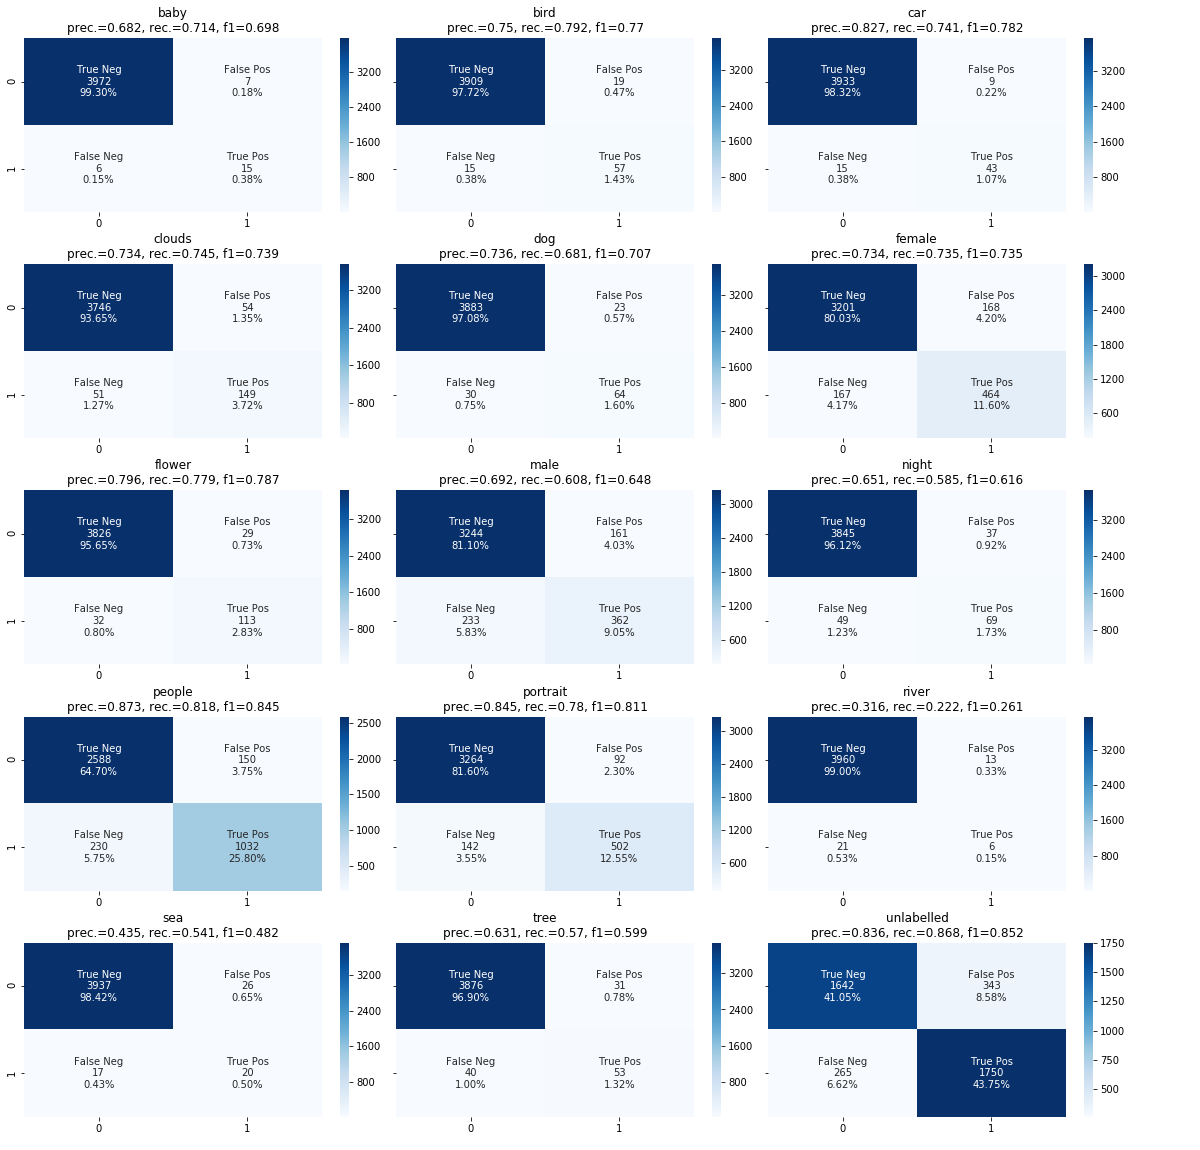

In [2335]:
# Save confusion matrix plot
labels = [k for k, v in get_class_map().items()] + ['unlabelled']

#tn, fp, fn, tp = 3750, 157, 21, 72
#y_true_no = [0]*tn + [0]*fp + [1]*fn + [1]*tp
#y_pred_no = [0]*tn + [1]*fp + [0]*fn + [1]*tp

# images and predictions that have no labels
y_true_no = (np.sum(y_true, axis=1) == 0).astype(int)
y_pred_no = (np.sum(y_pred, axis=1) == 0).astype(int)

# confusion matrix and scores for non-labelled images
cm, score = get_prediction_metrics(y_true_no, y_pred_no)

visualize_confusion_matrix(y_true, y_pred, labels, f'../results/{model_name}_confusion_matrix.png', 
                           no_label_cn=cm, no_label_score=score)

# Show confusion matrix plot
IPython_Image(filename=f'../results/{model_name}_confusion_matrix.png', width=1000)

# Final model

In [2400]:
# Load our best pre-trained model from disk to continue training on validation and test set
model = torch.load('../data/resnet152-epochs25-bs64-valid-F1-0.76.pth')
model_name = 'resnet152_train'

## Add our validation and test data and evaluate

In [2407]:
n_epochs = 1

if False:
    
    model_name = 'resnet152_train_valid'
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,max_lr=0.01, base_momentum=0.5, max_momentum=0.95, 
        steps_per_epoch=len(valid_dataloader), 
        epochs=n_epochs,)

    _, _, _, _, = train(valid_dataloader, valid_dataloader,\
        model, optimizer, scheduler, criterion, device,\
        n_epochs=n_epochs, verbose=False, threshold=threshold)
    
if True:
    
    model_name = 'resnet152_final'
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,max_lr=0.01, base_momentum=0.5, max_momentum=0.95, 
        steps_per_epoch=len(valid_dataloader), 
        epochs=n_epochs,)

    _, _, _, _, = train(valid_dataloader, valid_dataloader,\
        model, optimizer, scheduler, criterion, device,\
        n_epochs=n_epochs, verbose=False, threshold=threshold)

Epoch Train loss   Valid loss   Train F1  Valid F1 
1     1.0337639706 1.0318663373 0.7558327 0.7554693
Done training!


In [2408]:
# Predict 
y_true, y_pred = predict(model, device, test_dataloader, threshold=threshold)
y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy()

# Save results to disk
path_pred, path_true = f'../results/{model_name}_pred.txt', f'../results/{model_name}_true.txt'
np.savetxt(path_pred, y_pred, fmt='%d')
np.savetxt(path_true, y_true, fmt='%d')
print(f'Saved results in {path_pred}, {path_true}')

Saved results in ../results/resnet152_final_pred.txt, ../results/resnet152_final_true.txt


In [2409]:
%run "../scripts/test_eval.py" $path_pred $path_true

../results/resnet152_final_true.txt: f1=0.7540336622170632, prec=0.7033347769597228, recall=0.8126094570928196


In [2410]:
# Save a model on disk to continue training later
if True:
    model_whole_save_path = f'../data/resnet152-epochs27-bs64-valid-F1-0.75.pth'
    print(f'Saving model to {model_whole_save_path}')
    torch.save(model, model_whole_save_path)

Saving model to ../data/resnet152-epochs27-bs64-valid-F1-0.75.pth


# Predict and evaluate using actual test data

## Load our final model

In [2412]:
model = torch.load('../data/resnet152-epochs27-bs64-valid-F1-0.75.pth')

## Data paths for actual test data

In [2413]:
DATA_PATH2 = '../test_data'
#DATA_PATH2 = '../data'
IMAGE_PATH2 = f'{DATA_PATH2}/images'
LABEL_PATH2 = f'{DATA_PATH2}/annotations'

## Load actual test data

In [2414]:
# Load actual testset
if not os.path.isfile(f'{DATA_PATH2}/X_test_actual.dat'):
    print('Loading test data from disk.')
    
    # Use this when we have the actual test data: get the whole test data in one dataloader
    X_test_actual = get_test_data(test_image_path = IMAGE_PATH2)
    
    torch.save(X_test_actual, f'{DATA_PATH2}/X_test_actual.dat')
else:
    print('Loading saved torch dump of test images from disk.')
    X_test_actual = torch.load(f'{DATA_PATH2}/X_test_actual.dat')    

test_dataloader_actual = DataLoader(
    TransformingTestDataset(X_test_actual, transforms=transformations['test']),
    shuffle=False,
    batch_size=bs)

Loading saved torch dump of test images from disk.


## Predict for actual test data and save predictions on disk

In [2415]:
# Predict 
y_pred = predict_testdata(model, device, test_dataloader_actual, threshold=threshold)

# Save results to disk
path_pred_actual = f'../results/{model_name}_actual_pred.txt'
np.savetxt(path_pred_actual, y_pred.cpu(), fmt='%d')
print(f'Saved actual test data results in {path_pred_actual}')

Saved actual test data results in ../results/resnet152_final_actual_pred.txt


## Run test_eval.py using actual test set

In [2340]:
%run "../scripts/test_eval.py" $path_pred_actual $path_true

AssertionError: 